In [2]:
# Cell 2: imports and small setup
import os, re, string
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# nltk downloads (first run)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

print("Imports OK")


Imports OK


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# Cell 3: load the CSVs and inspect
fake_path = r"C:\27_python\Fake.csv"
true_path = r"C:\27_python\True.csv"

df_fake = pd.read_csv(fake_path)
df_true = pd.read_csv(true_path)

print("Fake columns:", df_fake.columns.tolist())
print("True columns:", df_true.columns.tolist())
print("Fake shape:", df_fake.shape, "True shape:", df_true.shape)

# show first 3 rows of each for screenshot
display(df_fake.head(3))
display(df_true.head(3))


Fake columns: ['title', 'text', 'subject', 'date']
True columns: ['title', 'text', 'subject', 'date']
Fake shape: (23481, 4) True shape: (21417, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"


In [4]:
# Cell 4: helper to standardize title/text column names
def standardize_text_columns(df):
    cols = [c.lower() for c in df.columns]
    # detect title
    title_col = None
    for c in ['title','headline','head']:
        if c in cols:
            title_col = df.columns[cols.index(c)]
            break
    # detect text
    text_col = None
    for c in ['text','content','article','body']:
        if c in cols:
            text_col = df.columns[cols.index(c)]
            break
    # rename if found
    mapping = {}
    if title_col:
        mapping[title_col] = 'title'
    if text_col:
        mapping[text_col] = 'text'
    df2 = df.rename(columns=mapping)
    if 'title' not in df2.columns:
        df2['title'] = ''
    if 'text' not in df2.columns:
        df2['text'] = ''
    return df2[['title','text']]

# Standardize both datasets
df_fake_std = standardize_text_columns(df_fake)
df_true_std = standardize_text_columns(df_true)

display(df_fake_std.head(2))
display(df_true_std.head(2))


,title,text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...


,title,text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...


In [5]:
# Cell 5: add label and combine
df_fake_std['label'] = 1   # fake
df_true_std['label'] = 0   # real

df = pd.concat([df_fake_std, df_true_std], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
print("Combined shape:", df.shape)
print("Label counts:\n", df['label'].value_counts())

# create a single text 'content' column (title + text)
df['content'] = (df['title'].fillna('') + ' . ' + df['text'].fillna('')).str.strip()
display(df[['title','label']].head(3))


Combined shape: (44898, 3)
Label counts:
 label
1    23481
0    21417
Name: count, dtype: int64


,title,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,1
1,Trump drops Steve Bannon from National Securit...,0
2,Puerto Rico expects U.S. to lift Jones Act shi...,0


In [6]:
# Cell 6: cleaning tokenization + lemmatization
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if pd.isnull(text):
        return ""
    s = str(text)
    s = re.sub(r'http\S+|www\.\S+', ' ', s)       # remove urls
    s = re.sub(r'@\w+|#\w+', ' ', s)              # mentions/hashtags
    s = re.sub(r'[^A-Za-z0-9\s]', ' ', s)
    #s = re.sub(r'[^A-Za-z\s]', ' ', s)            # remove punctuation/numbers
    s = re.sub(r'\s+', ' ', s).strip().lower()
    tokens = [lemmatizer.lemmatize(tok) for tok in s.split() if tok not in STOPWORDS and len(tok)>1]
    return " ".join(tokens)


In [7]:
# Cell 7: clean content (may take a few minutes)
tqdm.pandas(desc="Cleaning")
df['content_clean'] = df['content'].progress_apply(clean_text)

# show before/after on an example for screenshot
sample_idx = 0
print("Original (truncated):", df.loc[sample_idx,'content'][:400])
print("\nCleaned (truncated):", df.loc[sample_idx,'content_clean'][:400])


Cleaning: 100%|█████████████████████████████████████████████████████████████████| 44898/44898 [00:51<00:00, 876.76it/s]

Original (truncated): Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution . 21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films such as Ferris Bueller s Day Off) made some provocative statements on Judge Jeanine Pirro s show recently. While discussing the halt that was imposed on President Tr

Cleaned (truncated): ben stein call 9th circuit court committed coup tat constitution 21st century wire say ben stein reputable professor pepperdine university also hollywood fame appearing tv show film ferris bueller day made provocative statement judge jeanine pirro show recently discussing halt imposed president trump executive order travel stein referred judgement 9th circuit court washington state coup tat execut


In [8]:
# Cell 8: split into train/test (stratify by label)
X = df['content_clean'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
print("Train:", len(X_train), "Test:", len(X_test))


Train: 35918 Test: 8980


In [9]:
# Cell 9: TF-IDF
vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)


TF-IDF shapes: (35918, 15000) (8980, 15000)


In [10]:
# Cell 10: train Logistic Regression
lr = LogisticRegression(max_iter=1200, solver='saga', class_weight='balanced')
lr.fit(X_train_tfidf, y_train)

# predictions + report
y_pred_lr = lr.predict(X_test_tfidf)
y_proba_lr = lr.predict_proba(X_test_tfidf)[:,1]

print("LogisticRegression Report")
print(classification_report(y_test, y_pred_lr, digits=4))


LogisticRegression Report
              precision    recall  f1-score   support

           0     0.9863    0.9937    0.9900      4284
           1     0.9942    0.9874    0.9908      4696

    accuracy                         0.9904      8980
   macro avg     0.9903    0.9906    0.9904      8980
weighted avg     0.9905    0.9904    0.9904      8980



In [11]:
# Cell 11: Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)
y_proba_nb = nb.predict_proba(X_test_tfidf)[:,1]
print("MultinomialNB Report")
print(classification_report(y_test, y_pred_nb, digits=4))


MultinomialNB Report
              precision    recall  f1-score   support

           0     0.9467    0.9496    0.9481      4284
           1     0.9539    0.9512    0.9526      4696

    accuracy                         0.9504      8980
   macro avg     0.9503    0.9504    0.9503      8980
weighted avg     0.9505    0.9504    0.9504      8980



In [12]:
# Cell 12: Random Forest (faster config)
rf = RandomForestClassifier(n_estimators=150, n_jobs=-1, class_weight='balanced', random_state=42)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)
# rf may not have predict_proba if too slow; try:
try:
    y_proba_rf = rf.predict_proba(X_test_tfidf)[:,1]
except Exception:
    y_proba_rf = None
print("RandomForest Report")
print(classification_report(y_test, y_pred_rf, digits=4))


RandomForest Report
              precision    recall  f1-score   support

           0     0.9974    0.9988    0.9981      4284
           1     0.9989    0.9977    0.9983      4696

    accuracy                         0.9982      8980
   macro avg     0.9982    0.9982    0.9982      8980
weighted avg     0.9982    0.9982    0.9982      8980



In [13]:
# Cell 13: compare metrics in a DataFrame (for report table)
models = {
    'LogisticRegression': y_pred_lr,
    'MultinomialNB': y_pred_nb,
    'RandomForest': y_pred_rf
}
rows = []
for name, y_pred in models.items():
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    rows.append({'model':name, 'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1})
df_comp = pd.DataFrame(rows).sort_values('f1', ascending=False).reset_index(drop=True)
display(df_comp)
df_comp.to_csv("model_comparison.csv", index=False)   # save for repo


,model,accuracy,precision,recall,f1
0,RandomForest,0.998218,0.998934,0.997658,0.998295
1,LogisticRegression,0.990423,0.994211,0.987436,0.990812
2,MultinomialNB,0.950445,0.953876,0.951235,0.952554


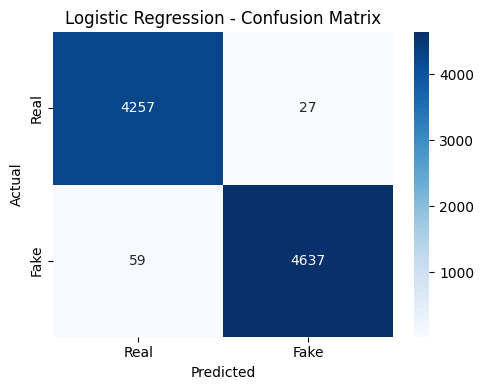

In [14]:
# Cell 14: confusion matrix and save image
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression - Confusion Matrix")
plt.tight_layout()
plt.savefig("cm_lr.png", dpi=150)
plt.show()


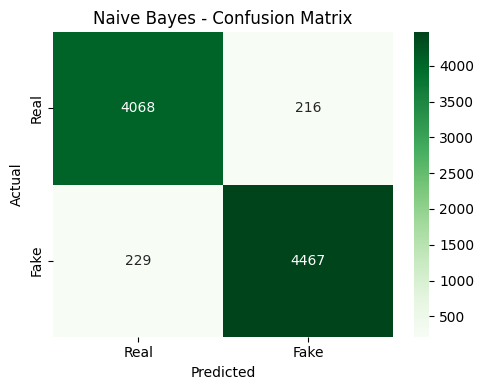

In [15]:
# Confusion Matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(5,4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Naive Bayes - Confusion Matrix")
plt.tight_layout()
plt.savefig("cm_nb.png", dpi=150)
plt.show()


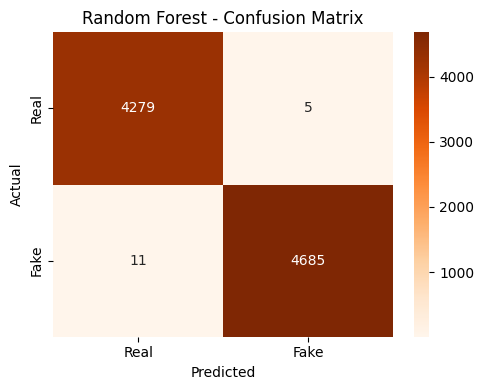

In [16]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest - Confusion Matrix")
plt.tight_layout()
plt.savefig("cm_rf.png", dpi=150)
plt.show()


In [22]:
# Cell 15: top tokens pushing toward fake/real from LR coefficients
def top_features_lr(model, vectorizer, n=20):
    coefs = model.coef_[0]
    fnames = np.array(vectorizer.get_feature_names_out())
    top_pos = fnames[np.argsort(coefs)[-n:][::-1]]
    top_pos_coefs = np.sort(coefs)[-n:][::-1]
    top_neg = fnames[np.argsort(coefs)[:n]]
    top_neg_coefs = np.sort(coefs)[:n]
    pos_df = pd.DataFrame({'feature':top_pos, 'coef':top_pos_coefs})
    neg_df = pd.DataFrame({'feature':top_neg, 'coef':top_neg_coefs})
    return pos_df, neg_df

pos_df, neg_df = top_features_lr(lr, vectorizer, n=25)
display(pos_df.head(12))
display(neg_df.head(12))
pos_df.to_csv("top_pos_features_lr.csv", index=False)
neg_df.to_csv("top_neg_features_lr.csv", index=False)


,feature,coef
0,via,9.517672
1,video,9.221644
2,image,6.032002
3,read,5.881975
4,hillary,5.493275
5,president trump,5.461715
6,gop,5.185082
7,obama,4.842053
8,watch,4.400288
9,mr,4.397591


,feature,coef
0,reuters,-22.082847
1,said,-16.130728
2,washington reuters,-9.052657
3,president donald,-5.084564
4,wednesday,-4.699687
5,washington,-4.685756
6,tuesday,-4.586862
7,reuters president,-4.492037
8,thursday,-3.952658
9,friday,-3.672333


In [19]:
# Cell 16: function to predict and give mitigation suggestion
def predict_and_mitigate(raw_text, model=lr, vec=vectorizer, topk=6):
    cleaned = clean_text(raw_text)
    Xv = vec.transform([cleaned])
    pred = model.predict(Xv)[0]
    try:
        proba = model.predict_proba(Xv)[0][1]
    except Exception:
        proba = None
    # top contributing words (present in doc)
    words = cleaned.split()
    feat_index = {f:i for i,f in enumerate(vec.get_feature_names_out())}
    coefs = model.coef_[0]
    weights = []
    for w in set(words):
        if w in feat_index:
            weights.append((w, float(coefs[feat_index[w]])))
    weights_sorted = sorted(weights, key=lambda x: abs(x[1]), reverse=True)[:topk]
    # mitigation message
    conf_str = f"{proba*100:.1f}%" if proba is not None else "N/A"
    if pred==1:
        msg = f"PREDICTION: FAKE (confidence {conf_str})\nTop suspicious tokens: {', '.join([w for w,_ in weights_sorted])}\nMitigation: Check source, cross-check with reputable outlets, consult fact-checkers (Snopes/PolitiFact)."
    else:
        msg = f"PREDICTION: REAL (confidence {conf_str})\nStill verify source & author if unsure."
    return pred, proba, weights_sorted, msg

# Demo: run on first 3 test samples and print mitigation suggestion
for i in range(3):
    sample = X_test[i]
    pred, proba, wts, msg = predict_and_mitigate(sample)
    print("Sample", i, "True:", y_test[i], "Pred:", pred, "Prob:", proba)
    print(msg)
    print("-"*80)


Sample 0 True: 1 Pred: 1 Prob: 0.9714931604463776
PREDICTION: FAKE (confidence 97.1%)
Top suspicious tokens: liberal, one, photo, great, anti, trump
Mitigation: Check source, cross-check with reputable outlets, consult fact-checkers (Snopes/PolitiFact).
--------------------------------------------------------------------------------
Sample 1 True: 0 Pred: 0 Prob: 0.03637186305903085
PREDICTION: REAL (confidence 3.6%)
Still verify source & author if unsure.
--------------------------------------------------------------------------------
Sample 2 True: 0 Pred: 0 Prob: 0.07527246127943338
PREDICTION: REAL (confidence 7.5%)
Still verify source & author if unsure.
--------------------------------------------------------------------------------
